In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glasses-and-coverings/glasses-and-coverings/sunglasses/sunglasses-uniform-para-soldier-army-paracommando-2389877.jpg
/kaggle/input/glasses-and-coverings/glasses-and-coverings/sunglasses/160607-f-zz999-876.jpg
/kaggle/input/glasses-and-coverings/glasses-and-coverings/sunglasses/100413-a-yg824-003.jpg
/kaggle/input/glasses-and-coverings/glasses-and-coverings/sunglasses/beautiful-cap-cold-eyewear.jpg
/kaggle/input/glasses-and-coverings/glasses-and-coverings/sunglasses/man-person-woman-hair-male-portrait-model-red-color-sunglass-fashion-clothing-black-lady-hairstyle-smile-cool-sunglasses-glasses-vision-care-138118.jpg
/kaggle/input/glasses-and-coverings/glasses-and-coverings/sunglasses/window-window-sill-wall-man-sunglasses-laugh.jpg
/kaggle/input/glasses-and-coverings/glasses-and-coverings/sunglasses/150904-m-ep064-040.jpg
/kaggle/input/glasses-and-coverings/glasses-and-coverings/sunglasses/160105-a-zz999-183.jpg
/kaggle/input/glasses-and-coverings/glasses-and-coverings/sung

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Original dataset directory (contains subfolders: plain, sunglasses, etc.)
ORIG_DATASET_DIR = "/kaggle/input/glasses-and-coverings/glasses-and-coverings"

# Only include these two classes:
CLASSES = ["plain", "sunglasses"]

# Working directory to store our new split (train/val/test)
SPLIT_DATASET_DIR = "/kaggle/working/split_dataset"

# Create subfolders: split_dataset/train, split_dataset/val, split_dataset/test
for subset in ["train", "val", "test"]:
    subset_path = os.path.join(SPLIT_DATASET_DIR, subset)
    os.makedirs(subset_path, exist_ok=True)
    # Inside each subset, create one folder per class
    for cls in CLASSES:
        os.makedirs(os.path.join(subset_path, cls), exist_ok=True)


In [4]:
import random
import shutil
def split_data(orig_dir, split_dir, classes, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Splits images from orig_dir into train/val/test in split_dir according to the given ratios.
    Only for specified classes in 'classes'.
    """
    for cls in classes:
        class_dir = os.path.join(orig_dir, cls)
        if not os.path.isdir(class_dir):
            print(f"Warning: class directory {class_dir} does not exist. Skipping.")
            continue
        
        # List all images in this class folder
        images = os.listdir(class_dir)
        images = [img for img in images if not img.startswith('.')]  # ignore hidden files
        random.shuffle(images)  # shuffle in place
        
        total_count = len(images)
        train_count = int(train_ratio * total_count)
        val_count   = int(val_ratio * total_count)
        # The remainder goes to test
        # (You could also do test_count = int(test_ratio * total_count), 
        #  then adjust for rounding, but this is usually fine)
        
        train_images = images[:train_count]
        val_images   = images[train_count : train_count + val_count]
        test_images  = images[train_count + val_count :]
        
        # Copy each group into split_dir
        for img_name in train_images:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_dir, "train", cls, img_name)
            shutil.copy(src, dst)
        
        for img_name in val_images:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_dir, "val", cls, img_name)
            shutil.copy(src, dst)
        
        for img_name in test_images:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_dir, "test", cls, img_name)
            shutil.copy(src, dst)
        
        print(f"Class '{cls}': total={total_count}, train={len(train_images)}, val={len(val_images)}, test={len(test_images)}")

# Actually perform the splitting
split_data(ORIG_DATASET_DIR, SPLIT_DATASET_DIR, CLASSES, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)


Class 'plain': total=497, train=347, val=74, test=76
Class 'sunglasses': total=488, train=341, val=73, test=74


In [5]:
def count_images_per_class(directory, classes_to_include):
    """
    Counts how many images are in each class subdirectory under 'directory'.
    """
    counts = {}
    for cls_name in classes_to_include:
        cls_path = os.path.join(directory, cls_name)
        if os.path.isdir(cls_path):
            counts[cls_name] = len([
                f for f in os.listdir(cls_path)
                if not f.startswith('.')  # ignore hidden files
            ])
    return counts

for subset in ["train", "val", "test"]:
    subset_path = os.path.join(SPLIT_DATASET_DIR, subset)
    distribution = count_images_per_class(subset_path, CLASSES)
    print(f"\n[{subset.upper()}] distribution:")
    for cls_name, count in distribution.items():
        print(f"  {cls_name}: {count} images")



[TRAIN] distribution:
  plain: 347 images
  sunglasses: 341 images

[VAL] distribution:
  plain: 74 images
  sunglasses: 73 images

[TEST] distribution:
  plain: 76 images
  sunglasses: 74 images


In [6]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

In [7]:
# Training Data Generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(SPLIT_DATASET_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,  # ensure only our two classes
    class_mode='categorical',
    shuffle=True
)

# Validation Data Generator (minimal augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(SPLIT_DATASET_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)

# Test Data Generator (no augmentation, just rescale)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(SPLIT_DATASET_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)

Found 688 images belonging to 2 classes.
Found 147 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Final classification layer (2 classes)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base_model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,986,786 (87.69 MB)

 Trainable params: 1,182,466 (4.51 MB)

 Non-trainable params: 21,804,320 (83.18 MB)

In [15]:
best_model_path = "best_inceptionv3_2class_sunglasses.keras"

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [16]:
EPOCHS = 100
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8265 - loss: 0.4378
Epoch 1: val_accuracy improved from -inf to 0.95918, saving model to best_inceptionv3_2class_sunglasses.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - accuracy: 0.8271 - loss: 0.4369 - val_accuracy: 0.9592 - val_loss: 0.1231
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8966 - loss: 0.2233
Epoch 2: val_accuracy improved from 0.95918 to 0.97279, saving model to best_inceptionv3_2class_sunglasses.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 711ms/step - accuracy: 0.8972 - loss: 0.2226 - val_accuracy: 0.9728 - val_loss: 0.1476
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9331 - loss: 0.1469
Epoch 3: val_accuracy did not improve from 0.97279
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 604ms/step - accuracy: 0.9329 - loss: 0.1474 - val_accuracy: 0.9660 - val_loss: 0.1807
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9458 - loss: 0.1961
Epoch 4: val_accuracy di

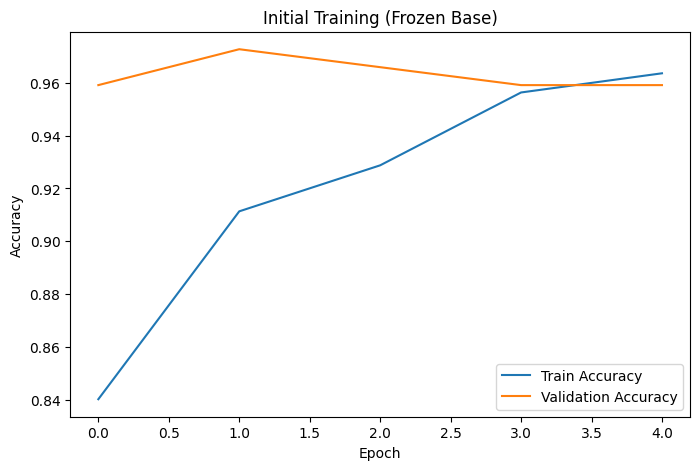

In [17]:
def plot_history(hist, title='Training History'):
    plt.figure(figsize=(8,5))
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history, "Initial Training (Frozen Base)")


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9085 - loss: 0.2252
Epoch 1: val_accuracy did not improve from 0.97279
22/22 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9090 - loss: 0.2243 - val_accuracy: 0.9592 - val_loss: 0.1722
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9489 - loss: 0.1446
Epoch 2: val_accuracy did not improve from 0.97279
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 613ms/step - accuracy: 0.9487 - loss: 0.1451 - val_accuracy: 0.9592 - val_loss: 0.1869
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9802 - loss: 0.0599
Epoch 3: val_accuracy did not improve from 0.97279
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 623ms/step - accuracy: 0.9797 - loss: 0.0610 - val_accuracy: 0.9660 - val_loss: 0.1973
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


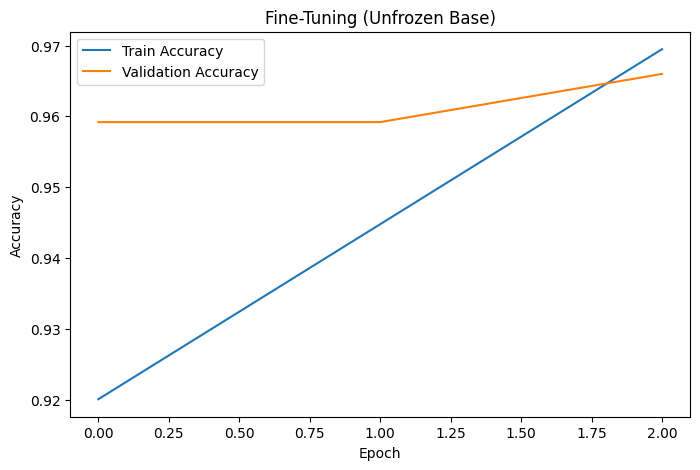

In [18]:
# Load best weights so far
model.load_weights(best_model_path)

# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

FINE_TUNE_EPOCHS = 10
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

plot_history(history_finetune, "Fine-Tuning (Unfrozen Base)")


In [19]:
# Load the best model from either phase
model.load_weights(best_model_path)

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 930ms/step - accuracy: 0.9855 - loss: 0.0601

Test Loss: 0.1077
Test Accuracy: 97.33%


In [21]:
final_model_path = "final_inceptionv3_2class_sunglasses(accuracy 97.33%).h5"
model.save(final_model_path)
print(f"\nModel saved to: {final_model_path}")


Model saved to: final_inceptionv3_2class_sunglasses(accuracy 97.33%).h5
